## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l1
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp=0, reg=0, bn=0):
    drp_ratio=0.2
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if reg==1:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l1(0.01))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            if drp==1:
                x = Dropout(drp_ratio)(x)
            if bn==1:
                x = BatchNormalization()(x)
        else:
            if reg==1:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l1(0.01))(x)
            else:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            if drp==1:
                x = Dropout(drp_ratio)(x)
            if bn==1:
                x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
EPOCHS = 50
BATCH_SIZE = 512
MOMENTUM = 0.95
DROPOUT = [0, 1]
REGULAR = [0, 1]
BATCHNORM = [0, 1]

In [7]:
results = {}
for bn, reg, drp in itertools.product(BATCHNORM, REGULAR, DROPOUT):
    model = build_mlp(input_shape=x_train.shape[1:], drp=drp, reg=reg, bn=bn)
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), shuffle=True, verbose=2)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = 'Dropout:'+(' True' if drp==1 else 'False')+' Regular:'+(' True' if reg==1 else 'False')+' BatchNorm:'+(' True' if bn==1 else 'False')
    results[exp_name_tag] = {'train-loss': train_loss, 'valid-loss': valid_loss, 'train-acc': train_acc, 'valid-acc': valid_acc}




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, valida

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 22s 431us/step - loss: 82.9582 - acc: 0.1117 - val_loss: 6.0211 - val_acc: 0.1000
Epoch 2/2
50000/50000 [==============================] - 17s 335us/step - loss: 4.6512 - acc: 0.0964 - val_loss: 4.4458 - val_acc: 0.1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normali

C:\Users\oldmon\.conda\envs\ai100-3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\oldmon\.conda\envs\ai100-3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


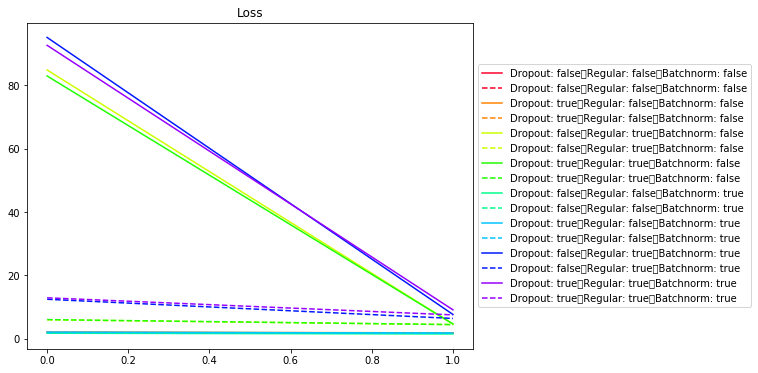

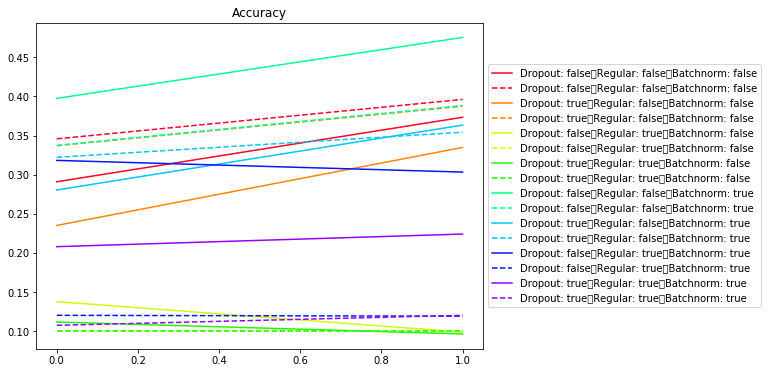

In [8]:
%matplotlib inline
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()